In [2]:
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_ohlcv_data(ticker_symbol, period="1y", interval="1d"):
    try:
        # Create a Ticker object
        ticker = yf.Ticker(ticker_symbol)

        # Download historical data
        # yfinance automatically returns OHLCV data
        print(f"Fetching {period} of {interval} data for {ticker_symbol}...")
        data = ticker.history(period=period, interval=interval)

        # Check if the dataframe is empty
        if data.empty:
            print(f"Error: No data found for ticker '{ticker_symbol}'. It might be an invalid ticker.")
            return None

        # The columns are already named 'Open', 'High', 'Low', 'Close', 'Volume'
        # 'Dividends' and 'Stock Splits' are also included by default
        return data

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

if __name__ == "__main__":
    # Set the ticker you want to analyze
    # Examples: 'AAPL' (Apple), 'GOOGL' (Google), 'MSFT' (Microsoft), 'TSLA' (Tesla)
    target_ticker = 'AAPL'

    # Fetch the data
    ohlcv_df = get_ohlcv_data(target_ticker, period="5y")

    # Display the data if fetching was successful
    if ohlcv_df is not None:
        print(f"\nSuccessfully downloaded data for {target_ticker}.")
        print("\n--- Data Info ---")
        ohlcv_df.info()

Fetching 5y of 1d data for AAPL...

Successfully downloaded data for AAPL.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-07-10 00:00:00-04:00 to 2025-07-10 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1256 non-null   float64
 1   High          1256 non-null   float64
 2   Low           1256 non-null   float64
 3   Close         1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Dividends     1256 non-null   float64
 6   Stock Splits  1256 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.5 KB


In [5]:
df = ohlcv_df.drop(['Volume','Dividends', 'Stock Splits'], axis=1)
# Keep only the date part (no time, no timezone)
df = df.reset_index()
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')

In [13]:
endog = df['Low']
exog = df.drop(columns=['Low'])

### 12 Months

--- Starting Cross-Validation ---
Split 1/5, Training size: 198, Validation size: 247
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Split 1: RMSE = 8.57
Split 1: RMSLE = 0.06
Split 2/5, Training size: 356, Validation size: 247
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Split 2: RMSE = 6.69
Split 2: RMSLE = 0.04
Split 3/5, Training size: 515, Validation size: 247
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step
Split 3: RMSE = 4.57
Split 3: RMSLE = 0.03
Split 4/5, Training size: 673, Validation size: 247
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Split 4: RMSE = 3.74
Split 4: RMSLE = 0.02
Split 5/5, Training size: 832, Validation size: 159
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Split 5: RMSE = 3.03
Split 5: RMSLE = 0.02

Average validation RMSE: 5.32

--- Training Final Model on All Data ---
--- Generating 250-Step Forecast ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/ste

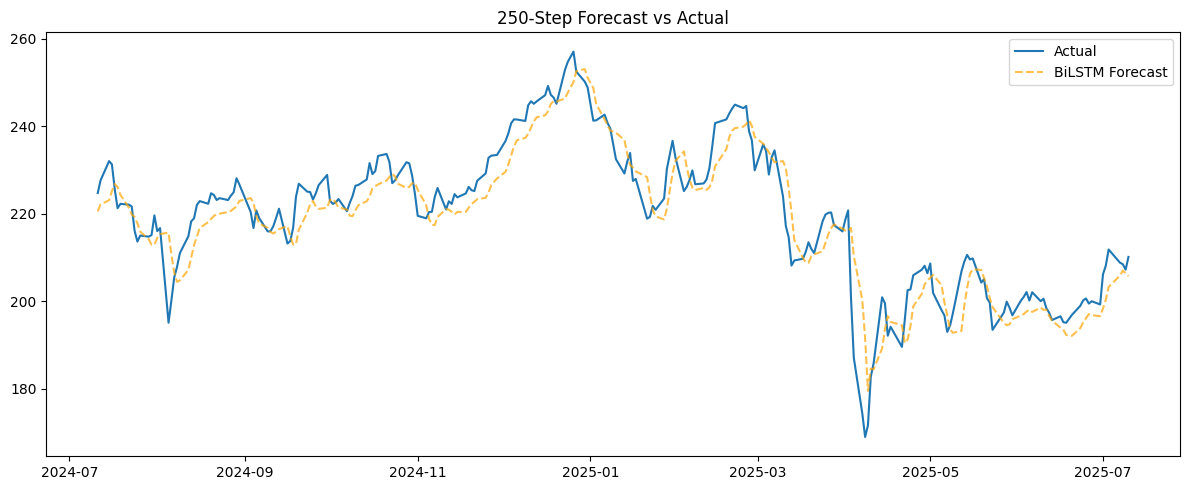

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, root_mean_squared_log_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Configuration ---
use_log_transform = True
sequence_length = 15  # <-- How many past days of data to use for a prediction
n_epochs = 100
batch_size = 32

# --- Optional log1p transform ---
if use_log_transform:
    endog_transformed = np.log1p(endog)
else:
    endog_transformed = endog.copy()

# Ensure datetime index
endog.index = pd.to_datetime(endog.index)
exog.index = pd.to_datetime(exog.index)

# --- Data Scaling ---
scaler_endog = MinMaxScaler()
endog_scaled = scaler_endog.fit_transform(endog_transformed.values.reshape(-1, 1)).flatten()

scaler_exog = MinMaxScaler()
exog_scaled = scaler_exog.fit_transform(exog)

endog_scaled_series = pd.Series(endog_scaled, index=endog_transformed.index)
exog_scaled_df = pd.DataFrame(exog_scaled, index=exog.index, columns=exog.columns)


# --- Sequence Generation Function ---
def create_sequences(endog_data, exog_data, seq_length):
    X, y = [], []
    for i in range(len(endog_data) - seq_length):
        # Endogenous sequence
        endog_seq = endog_data[i:(i + seq_length)]
        # Exogenous sequence
        exog_seq = exog_data[i:(i + seq_length)]

        # Combine into a single feature matrix for this timestep
        combined_seq = np.hstack([endog_seq.reshape(-1, 1), exog_seq])

        X.append(combined_seq)
        y.append(endog_data[i + seq_length])

    return np.array(X), np.array(y)

# --- Prepare data for the model ---
# Set forecast start date
forecast_start_date = pd.to_datetime("2024-07-11")
train_end_date = forecast_start_date - pd.Timedelta(days=1)

# --- FIX: Use .loc for slicing instead of a boolean mask ---
train_endog_scaled = endog_scaled_series.loc[:train_end_date]
train_exog_scaled = exog_scaled_df.loc[:train_end_date]

X_train, y_train = create_sequences(
    train_endog_scaled.values,
    train_exog_scaled.values,
    sequence_length
)
# --- End of fix ---


# Ground truth for test evaluation
true_test = endog.loc[forecast_start_date:exog.index[-1]]
forecast_steps = len(true_test)


# --- BILSTM Model Definition ---
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(LSTM(50, activation='relu')),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# --- Expanding window cross-validation ---
n_splits = 5
min_train_size = int(len(X_train) * 0.2)
val_scores = []

print("--- Starting Cross-Validation ---")
for i in range(n_splits):
    split_point = min_train_size + int((len(X_train) - min_train_size) * (i / n_splits))
    val_size = int(len(X_train) * 0.25)

    sub_X_train = X_train[:split_point]
    sub_y_train = y_train[:split_point]
    sub_X_val = X_train[split_point : split_point + val_size]
    sub_y_val = y_train[split_point : split_point + val_size]

    if len(sub_X_val) == 0: continue

    print(f"Split {i+1}/{n_splits}, Training size: {len(sub_X_train)}, Validation size: {len(sub_X_val)}")

    try:
        model = build_bilstm_model(input_shape=(sub_X_train.shape[1], sub_X_train.shape[2]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.fit(sub_X_train, sub_y_train,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  validation_data=(sub_X_val, sub_y_val),
                  callbacks=[early_stopping],
                  verbose=0) # Set to 1 to see training progress

        # Evaluate on validation set
        forecast_scaled = model.predict(sub_X_val).flatten()

        # Inverse transform for evaluation
        forecast_inv = scaler_endog.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
        true_vals_inv = scaler_endog.inverse_transform(sub_y_val.reshape(-1, 1)).flatten()

        if use_log_transform:
            forecast = np.exp(forecast_inv) - 1
            true_vals = np.exp(true_vals_inv) - 1
        else:
            forecast = forecast_inv
            true_vals = true_vals_inv

        forecast = np.clip(forecast, 0, None)

        rmse = root_mean_squared_error(true_vals, forecast)
        rmsle = root_mean_squared_log_error(true_vals, forecast)
        val_scores.append(rmse)

        print(f"Split {i+1}: RMSE = {rmse:.2f}")
        print(f"Split {i+1}: RMSLE = {rmsle:.2f}")
    except Exception as e:
        print(f"Split {i+1} failed. Error: {e}")
        val_scores.append(np.nan)

print(f"\nAverage validation RMSE: {np.nanmean(val_scores):.2f}")


# --- Final Model Training ---
print("\n--- Training Final Model on All Data ---")
final_model = build_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
final_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)


# --- Iterative Forecasting on Future Data ---
print(f"--- Generating {forecast_steps}-Step Forecast ---")
last_sequence = X_train[-1:]
forecasts = []

for i in range(forecast_steps):
    # Predict the next step
    next_pred_scaled = final_model.predict(last_sequence).flatten()[0]
    forecasts.append(next_pred_scaled)

    # Get the index for the next exogenous data point
    # Note: The index corresponds to the date of the value we are *predicting*
    next_date_index = true_test.index[i]

    # Ensure the date exists in the scaled exogenous data
    if next_date_index not in exog_scaled_df.index:
        print(f"Warning: Date {next_date_index.date()} not found in exogenous data. Stopping forecast.")
        break

    next_exog_scaled = exog_scaled_df.loc[next_date_index].values

    # Create the new step to be appended to the sequence
    new_step = np.hstack([next_pred_scaled, next_exog_scaled]).reshape(1, 1, -1)

    # Append the new prediction and corresponding exog features to the sequence
    new_sequence = np.append(last_sequence[:, 1:, :], new_step, axis=1)
    last_sequence = new_sequence


# --- Inverse Transform and Evaluate Forecast ---
forecast_scaled = np.array(forecasts).reshape(-1, 1)
forecast_inv = scaler_endog.inverse_transform(forecast_scaled)

if use_log_transform:
    final_forecast = np.exp(forecast_inv) - 1
else:
    final_forecast = forecast_inv

final_forecast = np.clip(final_forecast, 0, None).flatten()

# Create a pandas Series for the forecast with the correct index
# Ensure we only use the dates for which we have a forecast
forecast_index = true_test.index[:len(final_forecast)]
forecast_series = pd.Series(final_forecast, index=forecast_index)


# --- Evaluate Forecast ---
# Align true_test with the forecast series in case the forecast stopped early
aligned_true_test = true_test.loc[forecast_series.index]

test_rmsle = root_mean_squared_log_error(aligned_true_test, forecast_series)
test_mape = mean_absolute_percentage_error(aligned_true_test, forecast_series)

print(f"\nTest RMSLE ({len(forecast_series)} steps): {test_rmsle:.2f}")
print(f"Test MAPE: {test_mape * 100:.2f}%")


# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(aligned_true_test.index, aligned_true_test, label="Actual")
plt.plot(forecast_series.index, forecast_series, label="BiLSTM Forecast", linestyle='--', color='orange', alpha=0.7)
plt.title(f"{len(forecast_series)}-Step Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
model.save("aapl_low_bilstm.h5")